# 📝 Exercise M2.01

The aim of this exercise is to make the following experiments:

* train and test a support vector machine classifier through
  cross-validation;
* study the effect of the parameter gamma of this classifier using a
  validation curve;
* study if it would be useful in term of classification if we could add new
  samples in the dataset using a learning curve.

To make these experiments we will first load the blood transfusion dataset.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [2]:
%%bash

wget -qO "../../datasets/blood_transfusion.csv" "https://github.com/INRIA/scikit-learn-mooc/raw/master/datasets/blood_transfusion.csv"

In [3]:
import pandas as pd

blood_transfusion = pd.read_csv("../../datasets/blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

We will use a support vector machine classifier (SVM). In its most simple
form, a SVM classifier is a linear classifier behaving similarly to a
logistic regression. Indeed, the optimization used to find the optimal
weights of the linear model are different but we don't need to know these
details for the exercise.

Also, this classifier can become more flexible/expressive by using a
so-called kernel making the model becomes non-linear. Again, no requirement
regarding the mathematics is required to accomplish this exercise.

We will use an RBF kernel where a parameter `gamma` allows to tune the
flexibility of the model.

First let's create a predictive pipeline made of:

* a [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
  with default parameter;
* a [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
  where the parameter `kernel` could be set to `"rbf"`. Note that this is the
  default.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC())

Evaluate the statistical performance of your model by cross-validation with a
`ShuffleSplit` scheme. Thus, you can use
[`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
and pass a [`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)
to the `cv` parameter. Only fix the `random_state=0` in the `ShuffleSplit`
and let the other parameters to the default.

In [5]:
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(random_state=0)
cv_results = cross_validate(model, data, target, cv=cv, n_jobs=2)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.014246,0.002530,0.680000
1,0.013501,0.002563,0.746667
2,0.013239,0.002456,0.786667
3,0.012883,0.002447,0.800000
4,0.013546,0.002527,0.746667
5,0.013775,0.002411,0.786667
6,0.014686,0.002691,0.800000
7,0.012520,0.002495,0.826667
8,0.013687,0.002845,0.746667
9,0.012889,0.002416,0.733333


In [6]:
print(f"Accuracy score of our model:\n"
    f"{cv_results['test_score'].mean():.3f} +/- "
    f"{cv_results['test_score'].std():.3f}")

Accuracy score of our model:
0.765 +/- 0.043


As previously mentioned, the parameter `gamma` is one of the parameter
controlling under/over-fitting in support vector machine with an RBF kernel.

Compute the validation curve
(using [`sklearn.model_selection.validation_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html))
to evaluate the effect of the parameter `gamma`. You can vary its value
between `10e-3` and `10e2` by generating samples on a logarithmic scale.
Thus, you can use `np.logspace(-3, 2, num=30)`.

Since we are manipulating a `Pipeline` the parameter name will be set to
`svc__gamma` instead of only `gamma`. You can retrieve the parameter name
using `model.get_params().keys()`. We will go more into details regarding
accessing and setting hyperparameter in the next section.

In [9]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [10]:
import numpy as np
from sklearn.model_selection import validation_curve

gammas = np.logspace(-3, 2, num=30)
param_name = "svc__gamma"
train_scores, test_scores = validation_curve(model, data, target,
    param_name=param_name, param_range=gammas, cv=cv, n_jobs=2)

Plot the validation curve for the train and test scores.

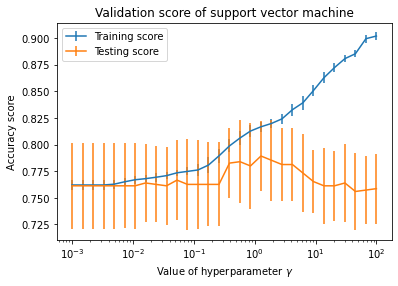

In [11]:
import matplotlib.pyplot as plt

plt.errorbar(gammas, train_scores.mean(axis=1), 
    yerr=train_scores.std(axis=1), label='Training score')
plt.errorbar(gammas, test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1), label='Testing score')
plt.legend()

plt.xscale('log')
plt.xlabel(r"Value of hyperparameter $\gamma$")
plt.ylabel("Accuracy score")
_ = plt.title("Validation score of support vector machine")

Looking at the curve, we can clearly identify the over-fitting regime of the SVC classifier when `gamma > 1`. The best setting is around `gamma = 1` while for `gamma < 1`, it is not very clear if the classifier is under-fitting but the testing score is worse than for `gamma = 1`.

Now, you can perform an analysis to check whether adding new samples to the
dataset could help our model to better generalize. Compute the learning curve
(using [`sklearn.model_selection.learning_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html))
by computing the train and test scores for different training dataset size.
Plot the train and test scores with respect to the number of samples.

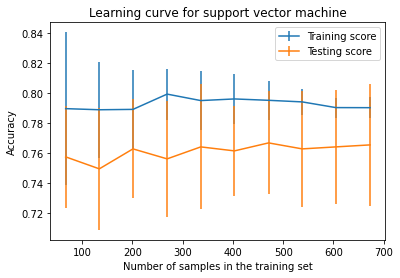

In [13]:
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1, num=10)
results = learning_curve(model, data, target, train_sizes=train_sizes,
    cv=cv, n_jobs=2)
train_size, train_scores, test_scores = results[:3]

plt.errorbar(train_size, train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1), label='Training score')
plt.errorbar(train_size, test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1), label='Testing score')
plt.legend()

plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
_ = plt.title("Learning curve for support vector machine")

We observe that adding new samples in the dataset doesn not improve the testing score. We can only conclude that the standard deviation of the training error is decreasing when adding more samples which is not a surprise.